### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
from itertools import product
import time

# for building DQN model
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("/home/kevin/Downloads/RL Project/TM.npy")

In [3]:
# checking the shape
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [4]:
States_track = collections.defaultdict(dict)

# function to initialise states to be tracked
def initialise_tracking_states():
    sample_q = [((1,2,2),(1,4)),((2,3,7),(2,4))]
    
    for samp in sample_q:
        state_tra = samp[0]
        action_tra = samp[1]
        States_track[state_tra][action_tra] = []


# saving the tracked state-action pair values
def save_tracking_states(learned_model):
    
    prod = product([1,2,3,4,5],[1,2,3,4,5])
    possible_actions = []
    for i in prod:
        if i[0]!=i[1]:
            possible_actions.append(i)
    possible_actions.append((0,0))
    
    for state in States_track.keys():
        for action in States_track[state].keys():
            m = np.zeros((1,5))
            m[0, int(state[0]-1)] = 1

            t = np.zeros((1,24))
            t[0, int(state[1]-1)] = 1

            d = np.zeros((1,7))
            d[0, int(state[2]-1)] = 1

            state_encod = np.concatenate((m,t,d), axis=None)
            q_values = learned_model.predict(np.array(state_encod).reshape(1,36)).ravel()  
            q_append = q_values[possible_actions.index(action)]
            States_track[state][action].append(q_append)

In [5]:
# Initialise states to be tracked
initialise_tracking_states()

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size 
        self.action_size =  action_size 

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001     
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0009
        self.epsilon_min = 0.00000001
        self.batch_size = 256        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        model.add(Dense(self.batch_size, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.batch_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    # method to keep track of the index of different actions
    def NN_out_action_index(self, action):   
        prod = product([1,2,3,4,5],[1,2,3,4,5])
        possible_actions = []
        for i in prod:
            if i[0]!=i[1]:
                possible_actions.append(i)
        possible_actions.append((0,0))
        return possible_actions.index(action)

    def get_action(self, state, episode, action_req, action_req_idx):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment   
        eps = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-0.0009*episode)

        if eps > np.random.rand():
            return random.choice(action_req)
        else:
            q_value = self.model.predict(np.array(state).reshape(1,36)).ravel()  
            choice_option_val = [q_value[i] for i in action_req_idx]
            index_max = np.argmax(choice_option_val)
            return action_req[index_max]           
                    
            
    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_target = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size)) 
            action, reward, done = [], [], []
            
            for i in range(self.batch_size):
                # Add current state s from the memory
                update_input[i] = mini_batch[i][0]
                # Add action from memory
                action.append(mini_batch[i][1])
                # Add reward from the memory
                reward.append(mini_batch[i][2])
                # Add next state s' to Q(s',a) from the memory
                update_target[i] = mini_batch[i][3]
                done.append(mini_batch[4])
                
            target = self.model.predict(update_input)   #output based on present state
            target_val = self.model.predict(update_target)  #output based on next state
            
            for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
                if done[i]:
                    target[i][self.NN_out_action_index(action[i])] = reward[i]   #target for the terminal state
                else:
                    target[i][self.NN_out_action_index(action[i])] = reward[i] + self.discount_factor * (np.amax(target_val[i]))
                
            # Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size,
                           epochs=1, verbose=0) 


    def save(self, name):
        self.model.save_weights(name)


In [8]:
# defining the no. of episodes
Episodes = 3000 

### DQN block

In [9]:
start_time = time.time()

episode_count=0   # episode count track

state_change_count = 0    # no. of state change track

total_reward_per_episode_track = []    # total reward per episode track
episode_reward_sum = 0    

#Call the DQN agent
dqn = DQNAgent(36,21) 


for episode in range(Episodes):

    # Call the environment
    cd = CabDriver()
    
    # Call all the initialised variables of the environment
    current_state = cd.state_init
    
    terminal_state = False    # defining the terminal state
    
    while terminal_state==False:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        poss_action_idx, poss_action = cd.requests(current_state)
        current_action = dqn.get_action(cd.state_encod_arch1(current_state), episode, poss_action, poss_action_idx)
        
        # 2. Evaluate your reward and next state
        reward = cd.reward_func(current_state, current_action, Time_matrix)
        episode_reward_sum+=reward
        
        next_state = cd.next_state_func(current_state, current_action, Time_matrix)
        
        state_change_count+=1
        
        if cd.week==4:   # week 4 is terminal state
            terminal_state=True
            total_reward_per_episode_track.append(episode_reward_sum)
            episode_reward_sum = 0
            save_tracking_states(dqn.model)
            episode_count+=1
            print('episode_count = ', episode_count)
        
        # 3. Append the experience to the memory
        dqn.append_sample(cd.state_encod_arch1(current_state), current_action, reward, cd.state_encod_arch1(next_state), terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        if state_change_count%20==0:
            dqn.train_model()
               
        current_state = next_state
        
    # saving the DQN model
    if episode%20==0:
        dqn.save('my_model.h5')
        
        
        
elapsed_time = time.time() - start_time
print('Total time taken = ', elapsed_time)

/home/kevin/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


episode_count =  1
episode_count =  2
episode_count =  3
episode_count =  4
episode_count =  5
episode_count =  6
episode_count =  7
episode_count =  8
episode_count =  9
episode_count =  10
episode_count =  11
episode_count =  12
episode_count =  13
episode_count =  14
episode_count =  15
episode_count =  16
episode_count =  17
episode_count =  18
episode_count =  19
episode_count =  20
episode_count =  21
episode_count =  22
episode_count =  23
episode_count =  24
episode_count =  25
episode_count =  26
episode_count =  27
episode_count =  28
episode_count =  29
episode_count =  30
episode_count =  31
episode_count =  32
episode_count =  33
episode_count =  34
episode_count =  35
episode_count =  36
episode_count =  37
episode_count =  38
episode_count =  39
episode_count =  40
episode_count =  41
episode_count =  42
episode_count =  43
episode_count =  44
episode_count =  45
episode_count =  46
episode_count =  47
episode_count =  48
episode_count =  49
episode_count =  50
episode_c

episode_count =  397
episode_count =  398
episode_count =  399
episode_count =  400
episode_count =  401
episode_count =  402
episode_count =  403
episode_count =  404
episode_count =  405
episode_count =  406
episode_count =  407
episode_count =  408
episode_count =  409
episode_count =  410
episode_count =  411
episode_count =  412
episode_count =  413
episode_count =  414
episode_count =  415
episode_count =  416
episode_count =  417
episode_count =  418
episode_count =  419
episode_count =  420
episode_count =  421
episode_count =  422
episode_count =  423
episode_count =  424
episode_count =  425
episode_count =  426
episode_count =  427
episode_count =  428
episode_count =  429
episode_count =  430
episode_count =  431
episode_count =  432
episode_count =  433
episode_count =  434
episode_count =  435
episode_count =  436
episode_count =  437
episode_count =  438
episode_count =  439
episode_count =  440
episode_count =  441
episode_count =  442
episode_count =  443
episode_count

episode_count =  788
episode_count =  789
episode_count =  790
episode_count =  791
episode_count =  792
episode_count =  793
episode_count =  794
episode_count =  795
episode_count =  796
episode_count =  797
episode_count =  798
episode_count =  799
episode_count =  800
episode_count =  801
episode_count =  802
episode_count =  803
episode_count =  804
episode_count =  805
episode_count =  806
episode_count =  807
episode_count =  808
episode_count =  809
episode_count =  810
episode_count =  811
episode_count =  812
episode_count =  813
episode_count =  814
episode_count =  815
episode_count =  816
episode_count =  817
episode_count =  818
episode_count =  819
episode_count =  820
episode_count =  821
episode_count =  822
episode_count =  823
episode_count =  824
episode_count =  825
episode_count =  826
episode_count =  827
episode_count =  828
episode_count =  829
episode_count =  830
episode_count =  831
episode_count =  832
episode_count =  833
episode_count =  834
episode_count

episode_count =  1171
episode_count =  1172
episode_count =  1173
episode_count =  1174
episode_count =  1175
episode_count =  1176
episode_count =  1177
episode_count =  1178
episode_count =  1179
episode_count =  1180
episode_count =  1181
episode_count =  1182
episode_count =  1183
episode_count =  1184
episode_count =  1185
episode_count =  1186
episode_count =  1187
episode_count =  1188
episode_count =  1189
episode_count =  1190
episode_count =  1191
episode_count =  1192
episode_count =  1193
episode_count =  1194
episode_count =  1195
episode_count =  1196
episode_count =  1197
episode_count =  1198
episode_count =  1199
episode_count =  1200
episode_count =  1201
episode_count =  1202
episode_count =  1203
episode_count =  1204
episode_count =  1205
episode_count =  1206
episode_count =  1207
episode_count =  1208
episode_count =  1209
episode_count =  1210
episode_count =  1211
episode_count =  1212
episode_count =  1213
episode_count =  1214
episode_count =  1215
episode_co

episode_count =  1544
episode_count =  1545
episode_count =  1546
episode_count =  1547
episode_count =  1548
episode_count =  1549
episode_count =  1550
episode_count =  1551
episode_count =  1552
episode_count =  1553
episode_count =  1554
episode_count =  1555
episode_count =  1556
episode_count =  1557
episode_count =  1558
episode_count =  1559
episode_count =  1560
episode_count =  1561
episode_count =  1562
episode_count =  1563
episode_count =  1564
episode_count =  1565
episode_count =  1566
episode_count =  1567
episode_count =  1568
episode_count =  1569
episode_count =  1570
episode_count =  1571
episode_count =  1572
episode_count =  1573
episode_count =  1574
episode_count =  1575
episode_count =  1576
episode_count =  1577
episode_count =  1578
episode_count =  1579
episode_count =  1580
episode_count =  1581
episode_count =  1582
episode_count =  1583
episode_count =  1584
episode_count =  1585
episode_count =  1586
episode_count =  1587
episode_count =  1588
episode_co

episode_count =  1917
episode_count =  1918
episode_count =  1919
episode_count =  1920
episode_count =  1921
episode_count =  1922
episode_count =  1923
episode_count =  1924
episode_count =  1925
episode_count =  1926
episode_count =  1927
episode_count =  1928
episode_count =  1929
episode_count =  1930
episode_count =  1931
episode_count =  1932
episode_count =  1933
episode_count =  1934
episode_count =  1935
episode_count =  1936
episode_count =  1937
episode_count =  1938
episode_count =  1939
episode_count =  1940
episode_count =  1941
episode_count =  1942
episode_count =  1943
episode_count =  1944
episode_count =  1945
episode_count =  1946
episode_count =  1947
episode_count =  1948
episode_count =  1949
episode_count =  1950
episode_count =  1951
episode_count =  1952
episode_count =  1953
episode_count =  1954
episode_count =  1955
episode_count =  1956
episode_count =  1957
episode_count =  1958
episode_count =  1959
episode_count =  1960
episode_count =  1961
episode_co

episode_count =  2290
episode_count =  2291
episode_count =  2292
episode_count =  2293
episode_count =  2294
episode_count =  2295
episode_count =  2296
episode_count =  2297
episode_count =  2298
episode_count =  2299
episode_count =  2300
episode_count =  2301
episode_count =  2302
episode_count =  2303
episode_count =  2304
episode_count =  2305
episode_count =  2306
episode_count =  2307
episode_count =  2308
episode_count =  2309
episode_count =  2310
episode_count =  2311
episode_count =  2312
episode_count =  2313
episode_count =  2314
episode_count =  2315
episode_count =  2316
episode_count =  2317
episode_count =  2318
episode_count =  2319
episode_count =  2320
episode_count =  2321
episode_count =  2322
episode_count =  2323
episode_count =  2324
episode_count =  2325
episode_count =  2326
episode_count =  2327
episode_count =  2328
episode_count =  2329
episode_count =  2330
episode_count =  2331
episode_count =  2332
episode_count =  2333
episode_count =  2334
episode_co

episode_count =  2663
episode_count =  2664
episode_count =  2665
episode_count =  2666
episode_count =  2667
episode_count =  2668
episode_count =  2669
episode_count =  2670
episode_count =  2671
episode_count =  2672
episode_count =  2673
episode_count =  2674
episode_count =  2675
episode_count =  2676
episode_count =  2677
episode_count =  2678
episode_count =  2679
episode_count =  2680
episode_count =  2681
episode_count =  2682
episode_count =  2683
episode_count =  2684
episode_count =  2685
episode_count =  2686
episode_count =  2687
episode_count =  2688
episode_count =  2689
episode_count =  2690
episode_count =  2691
episode_count =  2692
episode_count =  2693
episode_count =  2694
episode_count =  2695
episode_count =  2696
episode_count =  2697
episode_count =  2698
episode_count =  2699
episode_count =  2700
episode_count =  2701
episode_count =  2702
episode_count =  2703
episode_count =  2704
episode_count =  2705
episode_count =  2706
episode_count =  2707
episode_co

### Tracking Convergence

In [10]:
episode_count

3000

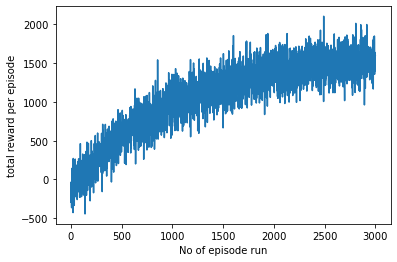

In [11]:
plt.plot(total_reward_per_episode_track[0:-1])
plt.xlabel('No of episode run')
plt.ylabel('total reward per episode')
plt.show()

From above, we note that our total reward per episodes is converging hence we can say that our DQN is learning to take the optimal decision.

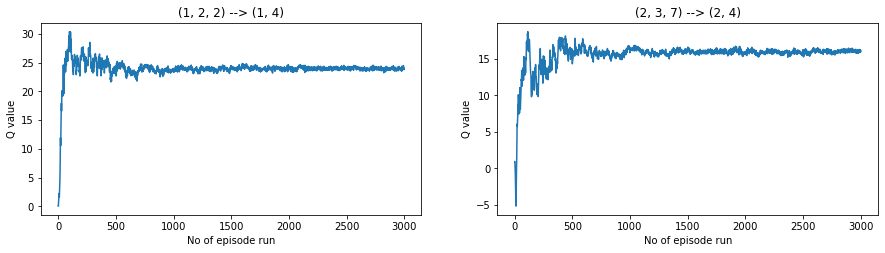

In [12]:
# plotting the graphs for state-action pairs tracked

i=1
plt.figure(figsize=(15, 12))
for state in States_track.keys():
    for action in States_track[state].keys():
        plt.subplot(3,2,i)
        i+=1
        plt.plot(States_track[state][action])
        plt.xlabel('No of episode run')
        plt.ylabel('Q value')
        plt.title(str(state)+' --> '+str(action))
        

The state-action Q values are also converging for our tracked states, as brought out above.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,3000)
epsilon = []
for i in range(0,3000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

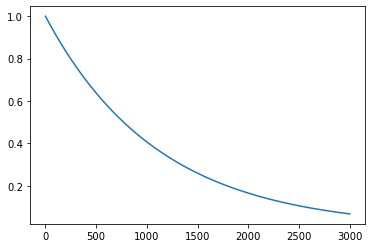

In [14]:
plt.plot(time, epsilon)
plt.show()